# Lab3 Simplified: DQR overview
本笔记本仅保留适用于 `ppr-group-25208508-train.csv` 的数据理解与数据质量检查代码，便于快速跑通并查看数据情况。


## 1) Imports 引入 环境变量

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 140)

sns.set_style('whitegrid')


## 2) Load Dataset 导入训练集

In [3]:
file_path = 'ppr-group-25208508-train.csv'
df = pd.read_csv(file_path, encoding='utf-8')

print(f'Loaded: {file_path}')
print(f'Shape: {df.shape}')
display(df.head())


Loaded: ppr-group-25208508-train.csv
Shape: (54000, 9)


,Date of Sale (dd/mm/yyyy),Address,County,Eircode,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
0,30/09/2016,"28 BRACKEN COURT, DONNYBROOK, CORK",Cork,NaN,"€181,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
1,20/12/2016,"2 AN CLOCHAR, CONVENT RD, DONERAILE",Cork,NaN,"€50,152.49",No,Yes,New Dwelling house /Apartment,less than 38 sq metres
2,28/09/2016,"Apartment 7 The Court, Clonattin, Gorey",Wexford,NaN,"€62,171.81",No,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...
3,16/09/2016,"6 Monalin, Wicklow Hills, Newtownmountkennedy",Wicklow,NaN,"€223,348.00",No,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...
4,29/01/2016,"18 Lislea, Frascati Park, Blackrock",Dublin,NaN,"€310,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN


## 3) Basic Structure Check 数据结构检查

In [4]:

print('Data types:')
display(df.dtypes.to_frame('dtype'))

print('Missing values:')
missing = df.isna().sum().sort_values(ascending=False)
display(missing.to_frame('missing_count'))

print('Cardinality / Top 5 Frequency:')
profile_rows = []
for c in df.columns:
    s = df[c]
    non_null_count = int(s.notna().sum())
    cardinality = int(s.nunique(dropna=True))

    vc = s.value_counts(dropna=True).head(5)
    top5_values = ' | '.join([str(v) for v in vc.index])
    top5_counts = ' | '.join([str(int(v)) for v in vc.values])
    top5_freq = ' | '.join([
        str(round((int(v) / non_null_count) * 100, 2)) if non_null_count > 0 else '0.0'
        for v in vc.values
    ])

    profile_rows.append({
        'feature': c,
        'non_null_count': non_null_count,
        'cardinality': cardinality,
        'top5_values': top5_values,
        'top5_counts': top5_counts,
        'top5_freq_%': top5_freq
    })

profile_df = pd.DataFrame(profile_rows).sort_values(['cardinality', 'non_null_count'], ascending=[False, False])
display(profile_df)



Data types:


,dtype
Date of Sale (dd/mm/yyyy),str
Address,str
County,str
Eircode,str
Price (€),str
Not Full Market Price,str
VAT Exclusive,str
Description of Property,str
Property Size Description,str


Missing values:


,missing_count
Property Size Description,51164
Eircode,37108
Date of Sale (dd/mm/yyyy),0
Address,0
County,0
Price (€),0
Not Full Market Price,0
VAT Exclusive,0
Description of Property,0


Cardinality / Top 5 Frequency:


,feature,non_null_count,cardinality,top5_values,top5_counts,top5_freq_%
1,Address,54000,53261,"AUGHNASEDA, MONAGHAN | ERREW, CASTLEHILL, BALL...",5 | 4 | 3 | 3 | 3,0.01 | 0.01 | 0.01 | 0.01 | 0.01
3,Eircode,16892,16823,D24W9NN | F45FN32 | D24YT67 | H91DNF4 | D02R658,4 | 2 | 2 | 2 | 2,0.02 | 0.01 | 0.01 | 0.01 | 0.01
4,Price (€),54000,6845,"€150,000.00 | €250,000.00 | €200,000.00 | €300...",619 | 596 | 577 | 492 | 486,1.15 | 1.1 | 1.07 | 0.91 | 0.9
0,Date of Sale (dd/mm/yyyy),54000,2487,18/12/2020 | 21/12/2020 | 22/12/2020 | 20/12/2...,107 | 102 | 97 | 95 | 89,0.2 | 0.19 | 0.18 | 0.18 | 0.16
2,County,54000,26,Dublin | Cork | Kildare | Galway | Meath,16592 | 5975 | 2926 | 2600 | 2325,30.73 | 11.06 | 5.42 | 4.81 | 4.31
8,Property Size Description,2836,4,greater than or equal to 38 sq metres and less...,2105 | 507 | 131 | 93,74.22 | 17.88 | 4.62 | 3.28
7,Description of Property,54000,3,Second-Hand Dwelling house /Apartment | New Dw...,44332 | 9665 | 3,82.1 | 17.9 | 0.01
5,Not Full Market Price,54000,2,No | Yes,51150 | 2850,94.72 | 5.28
6,VAT Exclusive,54000,2,No | Yes,44486 | 9514,82.38 | 17.62


## 4) cardinality check

In [5]:
import numpy as np
import pandas as pd

exclude_cols = ['Date of Sale (dd/mm/yyyy)']

if 'cat_cols' not in globals():
    cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

analysis_cols = [c for c in cat_cols if c not in exclude_cols and c in df.columns]

cat_summary = []
for c in analysis_cols:
    s = df[c]
    non_null_count = int(s.notna().sum())
    cardinality = int(s.nunique(dropna=True))

    vc = s.value_counts(dropna=True)
    top_value = vc.index[0] if len(vc) > 0 else np.nan
    top_count = int(vc.iloc[0]) if len(vc) > 0 else 0
    top_freq_pct = round((top_count / non_null_count) * 100, 2) if non_null_count > 0 else 0.0

    cat_summary.append({
        'feature': c,
        'dtype': str(s.dtype),
        'non_null_count': non_null_count,
        'missing_count': int(s.isna().sum()),
        'missing_%': round(s.isna().mean() * 100, 2),
        'cardinality': cardinality,
        'top_value': top_value,
        'top_count': top_count,
        'top_freq_%': top_freq_pct
    })

cat_summary_df = pd.DataFrame(cat_summary)

if not cat_summary_df.empty:
    cat_summary_df = cat_summary_df.sort_values(
        ['missing_%', 'cardinality'], ascending=[False, False]
    )
display(cat_summary_df)

for c in analysis_cols:
    print(f"\n=== {c} | cardinality={df[c].nunique(dropna=True)} | non_null={df[c].notna().sum()} ===")
    freq_df = (
        df[c]
        .value_counts(dropna=False)
        .rename_axis('value')
        .reset_index(name='count')
    )
    freq_df['frequency_%'] = (freq_df['count'] / len(df) * 100).round(2)
    display(freq_df.head(10))



,feature,dtype,non_null_count,missing_count,missing_%,cardinality,top_value,top_count,top_freq_%
7,Property Size Description,str,2836,51164,94.75,4,greater than or equal to 38 sq metres and less...,2105,74.22
2,Eircode,str,16892,37108,68.72,16823,D24W9NN,4,0.02
0,Address,str,54000,0,0.00,53261,"AUGHNASEDA, MONAGHAN",5,0.01
3,Price (€),str,54000,0,0.00,6845,"€150,000.00",619,1.15
1,County,str,54000,0,0.00,26,Dublin,16592,30.73
6,Description of Property,str,54000,0,0.00,3,Second-Hand Dwelling house /Apartment,44332,82.10
4,Not Full Market Price,str,54000,0,0.00,2,No,51150,94.72
5,VAT Exclusive,str,54000,0,0.00,2,No,44486,82.38



=== Address | cardinality=53261 | non_null=54000 ===


,value,count,frequency_%
0,"AUGHNASEDA, MONAGHAN",5,0.01
1,"ERREW, CASTLEHILL, BALLINA",4,0.01
2,"BRAMBLE COTTAGE, NEWMARKET ON FERGUS, CO CLARE",3,0.01
3,"MAIN ST, STRADBALLY, LAOIS",3,0.01
4,"85 KILLEEN WOOD, TRALEE, KERRY",3,0.01
5,"STRADBALLY EAST, CLARINBRIDGE, GALWAY",3,0.01
6,"THE HATCHERY, HATCHERY LANE, INISTIOGE",3,0.01
7,"52 ROCKBARTON PARK, SALTHILL, GALWAY",3,0.01
8,"MCCURTAIN ST, CLONES, MONAGHAN",3,0.01
9,"FARRNASTACK, LISSELTON, CO KERRY",3,0.01



=== County | cardinality=26 | non_null=54000 ===


,value,count,frequency_%
0,Dublin,16592,30.73
1,Cork,5975,11.06
2,Kildare,2926,5.42
3,Galway,2600,4.81
4,Meath,2325,4.31
5,Limerick,2063,3.82
6,Wicklow,1924,3.56
7,Wexford,1883,3.49
8,Tipperary,1538,2.85
9,Louth,1534,2.84



=== Eircode | cardinality=16823 | non_null=16892 ===


,value,count,frequency_%
0,NaN,37108,68.72
1,D24W9NN,4,0.01
2,F45FN32,2,0.00
3,D24YT67,2,0.00
4,H91DNF4,2,0.00
5,D02R658,2,0.00
6,N39YR29,2,0.00
7,D24H5YV,2,0.00
8,D09A0P0,2,0.00
9,A82AE06,2,0.00



=== Price (€) | cardinality=6845 | non_null=54000 ===


,value,count,frequency_%
0,"€150,000.00",619,1.15
1,"€250,000.00",596,1.10
2,"€200,000.00",577,1.07
3,"€300,000.00",492,0.91
4,"€100,000.00",486,0.90
5,"€180,000.00",458,0.85
6,"€220,000.00",456,0.84
7,"€190,000.00",450,0.83
8,"€120,000.00",431,0.80
9,"€275,000.00",429,0.79



=== Not Full Market Price | cardinality=2 | non_null=54000 ===


,value,count,frequency_%
0,No,51150,94.72
1,Yes,2850,5.28



=== VAT Exclusive | cardinality=2 | non_null=54000 ===


,value,count,frequency_%
0,No,44486,82.38
1,Yes,9514,17.62



=== Description of Property | cardinality=3 | non_null=54000 ===


,value,count,frequency_%
0,Second-Hand Dwelling house /Apartment,44332,82.10
1,New Dwelling house /Apartment,9665,17.90
2,Teach/Árasán Cónaithe Atháimhe,3,0.01



=== Property Size Description | cardinality=4 | non_null=2836 ===


,value,count,frequency_%
0,NaN,51164,94.75
1,greater than or equal to 38 sq metres and less...,2105,3.90
2,greater than or equal to 125 sq metres,507,0.94
3,less than 38 sq metres,131,0.24
4,greater than 125 sq metres,93,0.17


## 5) Data Type Preparation 数据结构整理


In [6]:
# Date parsing
if 'Date of Sale (dd/mm/yyyy)' in df.columns:
    df['Date of Sale (dd/mm/yyyy)'] = pd.to_datetime(
        df['Date of Sale (dd/mm/yyyy)'],
        dayfirst=True,
        errors='coerce'
    )

# Convert price to numeric once for all downstream cells
if 'Price (€)' in df.columns:
    raw_price = df['Price (€)'].astype(str).str.strip()
    df['Price (€)'] = pd.to_numeric(
        raw_price.str.replace('€', '', regex=False).str.replace(',', '', regex=False),
        errors='coerce'
    )
    # Cache numeric price for downstream reuse
    price_num = df['Price (€)']

# Convert common binary text fields to category for cleaner profiling
for col in ['Not Full Market Price', 'VAT Exclusive', 'County', 'Description of Property', 'Property Size Description']:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Create simple date features for quick inspection
if 'Date of Sale (dd/mm/yyyy)' in df.columns:
    df['Sale Year'] = df['Date of Sale (dd/mm/yyyy)'].dt.year.astype('category')
    df['Sale Month'] = df['Date of Sale (dd/mm/yyyy)'].dt.month.astype('category')

print('Updated dtypes:')
display(df.dtypes.to_frame('dtype'))


Updated dtypes:


,dtype
Date of Sale (dd/mm/yyyy),datetime64[us]
Address,str
County,category
Eircode,str
Price (€),float64
Not Full Market Price,category
VAT Exclusive,category
Description of Property,category
Property Size Description,category
Sale Year,category


## 6) Duplicates and Constant Columns 重复检查

In [27]:
duplicate_count = df.duplicated().sum()
print(f'Duplicate rows: {duplicate_count}')

# 新增：删除重复行（保留第一次出现）
if duplicate_count > 0:
    df = df.drop_duplicates(keep='first').reset_index(drop=True)
    print(f'Removed duplicate rows: {duplicate_count}')
    print(f'New shape: {df.shape}')
else:
    print('No duplicate rows removed.')

constant_cols = [c for c in df.columns if df[c].nunique(dropna=False) <= 1]
print(f'Constant columns ({len(constant_cols)}): {constant_cols}')

dup_cols = []
cols = df.columns
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        if df[cols[i]].equals(df[cols[j]]):
            dup_cols.append((cols[i], cols[j]))
print("Removing duplicate columns...")
print(f"Duplicate column pairs: {len(dup_cols)}")
print(dup_cols[:10])

# Remove duplicate columns
for col1, col2 in dup_cols:
    df = df.drop(columns=[col2])

Duplicate rows: 0
No duplicate rows removed.
Constant columns (0): []
Removing duplicate columns...
Duplicate column pairs: 0
[]


## 7)Price Quality Checks (Rules/Thresholds) 价格检查

In [8]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

print('Numeric columns:', numeric_cols)
print('Categorical/date columns:', cat_cols)

if numeric_cols:
    print('Numeric summary:')
    display(df[numeric_cols].describe().T)


Numeric columns: ['Price (€)']
Categorical/date columns: ['Date of Sale (dd/mm/yyyy)', 'Address', 'County', 'Eircode', 'Not Full Market Price', 'VAT Exclusive', 'Description of Property', 'Property Size Description', 'Sale Year', 'Sale Month']
Numeric summary:


,count,mean,std,min,25%,50%,75%,max
Price (€),54000.0,340638.819917,1.662132e+06,5250.0,157000.0,250000.0,365000.0,225000000.0


# 7.1)price clamping std check

In [9]:
# Price quality checks (reuse preprocessed price series)
col = 'Price (€)'
if col not in df.columns:
    raise KeyError("Column 'Price (€)' not found in df")

if 'price_num' not in globals():
    price_num = pd.to_numeric(df[col], errors='coerce')

# Quantile boundaries (cached for downstream reuse)
price_quantiles = price_num.quantile([0.01, 0.02, 0.05, 0.95, 0.98, 0.99])
p1, p2, p5 = price_quantiles.loc[0.01], price_quantiles.loc[0.02], price_quantiles.loc[0.05]
p95, p98, p99 = price_quantiles.loc[0.95], price_quantiles.loc[0.98], price_quantiles.loc[0.99]

print(f"5% boundary:  {p5:,.2f}")
print(f"95% boundary: {p95:,.2f}")
print(f"2% boundary:  {p2:,.2f}")
print(f"98% boundary: {p98:,.2f}")
print(f"1% boundary:  {p1:,.2f}")
print(f"99% boundary: {p99:,.2f}")

# IQR boundaries
q1 = price_num.quantile(0.25)
q3 = price_num.quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

price_bounds = {
    'q1': q1,
    'q3': q3,
    'iqr': iqr,
    'lower_bound': lower_bound,
    'upper_bound': upper_bound,
}

print(f"Upper bound: {upper_bound:,.2f}")
print(f"Lower bound: {lower_bound:,.2f}")  # Price cannot be negative in practice


5% boundary:  60,000.00
95% boundary: 703,000.00
2% boundary:  37,500.00
98% boundary: 1,000,000.00
1% boundary:  27,000.00
99% boundary: 1,500,000.00
Upper bound: 677,000.00
Lower bound: -155,000.00


### 7.2) original price check and clamping as 5% to 95% of the price

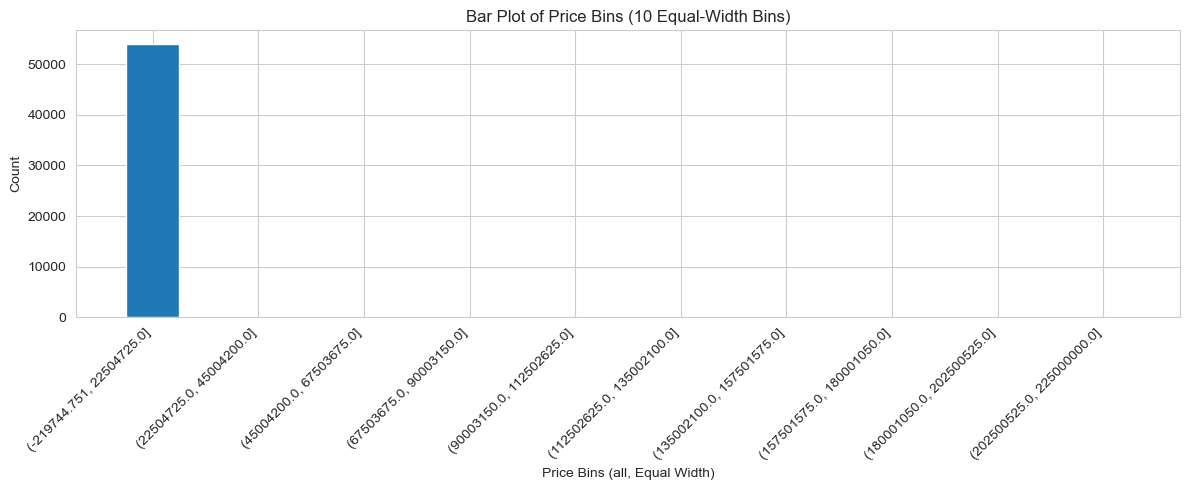

In [10]:
# Price bins on full range (reuse cached price_num)
if 'price_num' not in globals():
    price_num = pd.to_numeric(df['Price (€)'], errors='coerce')

x = price_num.dropna()
bins = pd.cut(x, bins=10, include_lowest=True, right=True)
freq = bins.value_counts(sort=False)

plt.figure(figsize=(12, 5))
plt.bar(range(len(freq)), freq.values, width=0.5)
plt.xticks(range(len(freq)), [str(i) for i in freq.index], rotation=45, ha='right')
plt.xlabel('Price Bins (all, Equal Width)')
plt.ylabel('Count')
plt.title('Bar Plot of Price Bins (10 Equal-Width Bins)')
plt.tight_layout()
plt.show()


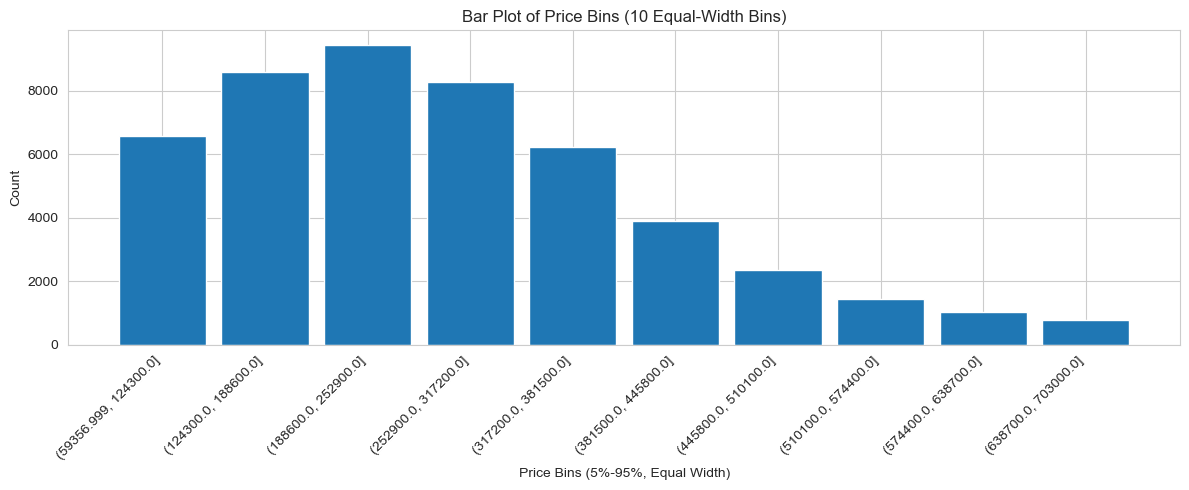

In [11]:
# Price bins on central range (5%-95%) using cached quantiles
if 'price_num' not in globals():
    price_num = pd.to_numeric(df['Price (€)'], errors='coerce')

if 'p5' not in globals() or 'p95' not in globals():
    p5, p95 = price_num.quantile([0.05, 0.95])

x = price_num[(price_num >= p5) & (price_num <= p95)].dropna()
bins = pd.cut(x, bins=10, include_lowest=True, right=True)
freq = bins.value_counts(sort=False)

plt.figure(figsize=(12, 5))
plt.bar(range(len(freq)), freq.values, width=0.85)
plt.xticks(range(len(freq)), [str(i) for i in freq.index], rotation=45, ha='right')
plt.xlabel('Price Bins (5%-95%, Equal Width)')
plt.ylabel('Count')
plt.title('Bar Plot of Price Bins (10 Equal-Width Bins)')
plt.tight_layout()
plt.show()


## 8) Quick Visual Checks on Price Distribution


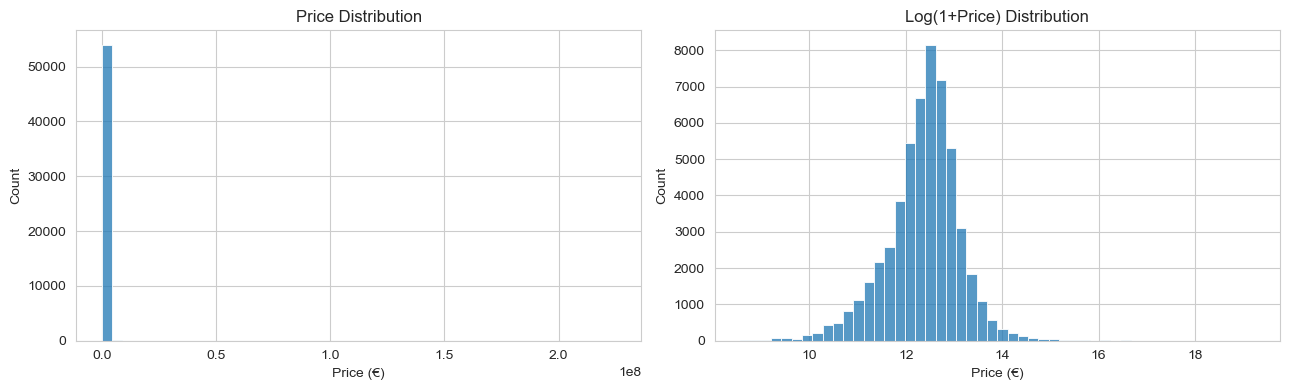

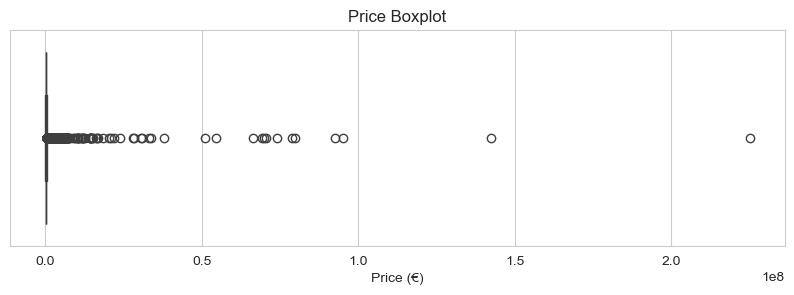

,Date of Sale (dd/mm/yyyy),Address,County,Eircode,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Sale Year,Sale Month
46346,2023-02-10,"O'Devaney Gardens, Arbour Hill, Dublin 7",Dublin,NaN,2.250000e+08,Yes,Yes,New Dwelling house /Apartment,NaN,2023,2
20376,2019-12-23,"Blocks A and C, The Point Campus",Dublin,NaN,1.422566e+08,No,Yes,New Dwelling house /Apartment,NaN,2019,12
22266,2019-05-27,"Apartments 1-164 Fairwary Court, &amp; 1-50 Fa...",Dublin,NaN,9.524229e+07,No,Yes,New Dwelling house /Apartment,NaN,2019,5
46858,2023-12-20,"Blocks D1 D2 D3 and D4, Cúil Dúin Avenue, Ci...",Dublin,NaN,9.251101e+07,No,Yes,New Dwelling house /Apartment,NaN,2023,12
49095,2024-06-27,"Blocks 5A-5D (including basement), Belmayne Av...",Dublin,NaN,7.973568e+07,No,Yes,New Dwelling house /Apartment,NaN,2024,6
49235,2024-02-12,"Barnwell Park, Hansfield",Dublin,NaN,7.886671e+07,No,Yes,New Dwelling house /Apartment,NaN,2024,2
37618,2022-10-07,"Apartments 1 - 190, Balroy House, Carpentersto...",Dublin,NaN,7.407876e+07,No,Yes,New Dwelling house /Apartment,NaN,2022,10
48867,2024-12-09,"BLOCK B, AIRTON PLAZA, TALLAGHT",Dublin,NaN,7.037500e+07,No,Yes,New Dwelling house /Apartment,NaN,2024,12
17484,2018-07-27,"182 THE ELYSIAN, EGLINTON STREET, CORK",Cork,NaN,6.987348e+07,Yes,No,Second-Hand Dwelling house /Apartment,NaN,2018,7
1716,2016-12-19,"Binary Hub Roe's Lane, Bonham Street",Dublin,NaN,6.920816e+07,No,No,New Dwelling house /Apartment,greater than or equal to 125 sq metres,2016,12


In [12]:
# Price distribution (target)
price_col = 'Price (€)'
if price_col in df.columns:
    if 'price_num' not in globals():
        price_num = pd.to_numeric(df[price_col], errors='coerce')
    price_numeric = price_num.dropna()

    fig, axes = plt.subplots(1, 2, figsize=(13, 4))

    sns.histplot(price_numeric, bins=50, ax=axes[0])
    axes[0].set_title('Price Distribution')

    sns.histplot(np.log1p(price_numeric), bins=50, ax=axes[1])
    axes[1].set_title('Log(1+Price) Distribution')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 2.8))
    sns.boxplot(x=price_numeric)
    plt.title('Price Boxplot')
    plt.show()

# Top 20 records by price (descending)
top20_by_price = df.sort_values(by='Price (€)', ascending=False).head(20)
display(top20_by_price)


**Price Max Record Note**
The maximum `Price (€)` record appears to have insufficiently detailed address information and may represent a whole building transaction or a multi-unit sale. Due to this coarse granularity, it is difficult to extract reliable property-level features from this record.


## 9) Save a Cleaned Preview CSV (Optional)


In [13]:
# Keep this as a preview output for your own checks
out_file = 'ppr-group-25208508-train-lab3-preview.csv'
df.to_csv(out_file, index=False, encoding='utf-8')
print(f'Saved: {out_file}')


Saved: ppr-group-25208508-train-lab3-preview.csv


# 10) Make DQR Report 


## 10.1) Data Validation 数据验证
快速检查数据规模、空列、重复记录和关键字段有效性。

In [28]:
# Data validation checks: only duplicate rows/columns
rows, cols = df.shape
print(f"Rows: {rows}, Columns: {cols}")

# Reuse from previous section if available
if 'duplicate_count' not in globals():
    duplicate_count = int(df.duplicated().sum())
print(f"Duplicate rows: {duplicate_count}")

if 'dup_cols' not in globals():
    dup_cols = []
    cols_list = df.columns.tolist()
    for i in range(len(cols_list)):
        for j in range(i + 1, len(cols_list)):
            if df[cols_list[i]].equals(df[cols_list[j]]):
                dup_cols.append((cols_list[i], cols_list[j]))

print(f"Duplicate column pairs: {len(dup_cols)}")
print(dup_cols[:10])


Rows: 53991, Columns: 11
Duplicate rows: 0
Duplicate column pairs: 0
[]


## 10.2) Standard DQR Tables 标准化报告表
输出与 Lab3 风格一致的数值和类别特征质量报告。

In [15]:
# Build standard DQR tables (Lab3-like format)
def build_numeric_dqr(df, columns):
    if not columns:
        return pd.DataFrame()
    stats = df[columns].describe().T
    miss_pct = 100 * (df[columns].isna().sum() / len(df))
    card = df[columns].nunique(dropna=True)
    dqr = pd.concat(
        [stats, miss_pct.rename('%missing'), card.rename('cardinality')],
        axis=1
    )
    return dqr.sort_values(['%missing', 'cardinality'], ascending=[False, False])


def build_categorical_dqr(df, columns):
    if not columns:
        return pd.DataFrame()
    desc = df[columns].describe(include='all').T
    miss_pct = 100 * (df[columns].isna().sum() / len(df))
    card = df[columns].nunique(dropna=True)
    dqr = pd.concat(
        [desc, miss_pct.rename('%missing'), card.rename('cardinality')],
        axis=1
    )
    return dqr.sort_values(['%missing', 'cardinality'], ascending=[False, False])

numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = df.select_dtypes(include=['object', 'str', 'category']).columns.tolist()

numeric_dqr = build_numeric_dqr(df, numeric_columns)
categorical_dqr = build_categorical_dqr(df, categorical_columns)

print('Numeric DQR table:')
display(numeric_dqr)
print('Categorical DQR table:')
display(categorical_dqr)


Numeric DQR table:


,count,mean,std,min,25%,50%,75%,max,%missing,cardinality
Price (€),54000.0,340638.819917,1.662132e+06,5250.0,157000.0,250000.0,365000.0,225000000.0,0.0,6845


Categorical DQR table:


,count,unique,top,freq,%missing,cardinality
Property Size Description,2836,4,greater than or equal to 38 sq metres and less...,2105,94.748148,4
Eircode,16892,16823,D24W9NN,4,68.718519,16823
Address,54000,53261,"AUGHNASEDA, MONAGHAN",5,0.000000,53261
County,54000,26,Dublin,16592,0.000000,26
Sale Month,54000,12,12,6449,0.000000,12
Sale Year,54000,9,2016,6000,0.000000,9
Description of Property,54000,3,Second-Hand Dwelling house /Apartment,44332,0.000000,3
Not Full Market Price,54000,2,No,51150,0.000000,2
VAT Exclusive,54000,2,No,44486,0.000000,2


## 10.3) Missingness Visual 缺失值可视化

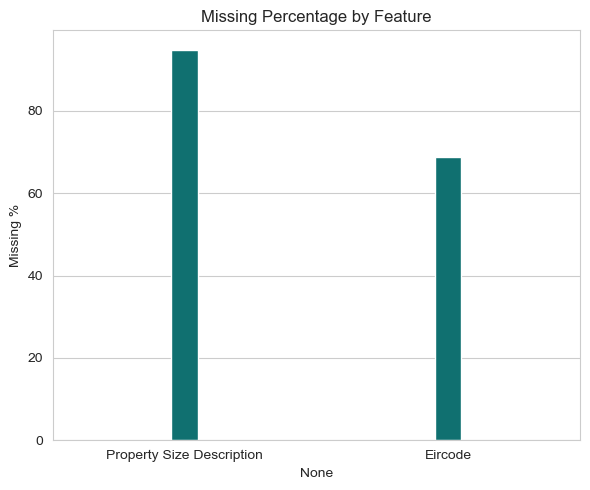

In [16]:
# Missing value percentage bar chart
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
missing_pct = missing_pct[missing_pct > 0]

plt.figure(figsize=(6, 5))
if len(missing_pct) > 0:
    sns.barplot(x=missing_pct.index, y=missing_pct.values, color='teal',width=0.1)
    plt.xticks( ha='center')
    plt.ylabel('Missing %')
    plt.title('Missing Percentage by Feature')
else:
    plt.text(0.5, 0.5, 'No missing values detected', ha='center', va='center')
    plt.title('Missing Percentage by Feature')
plt.tight_layout()
plt.show()


## 10.4) Visualizing Categorical Features 类别特征分布

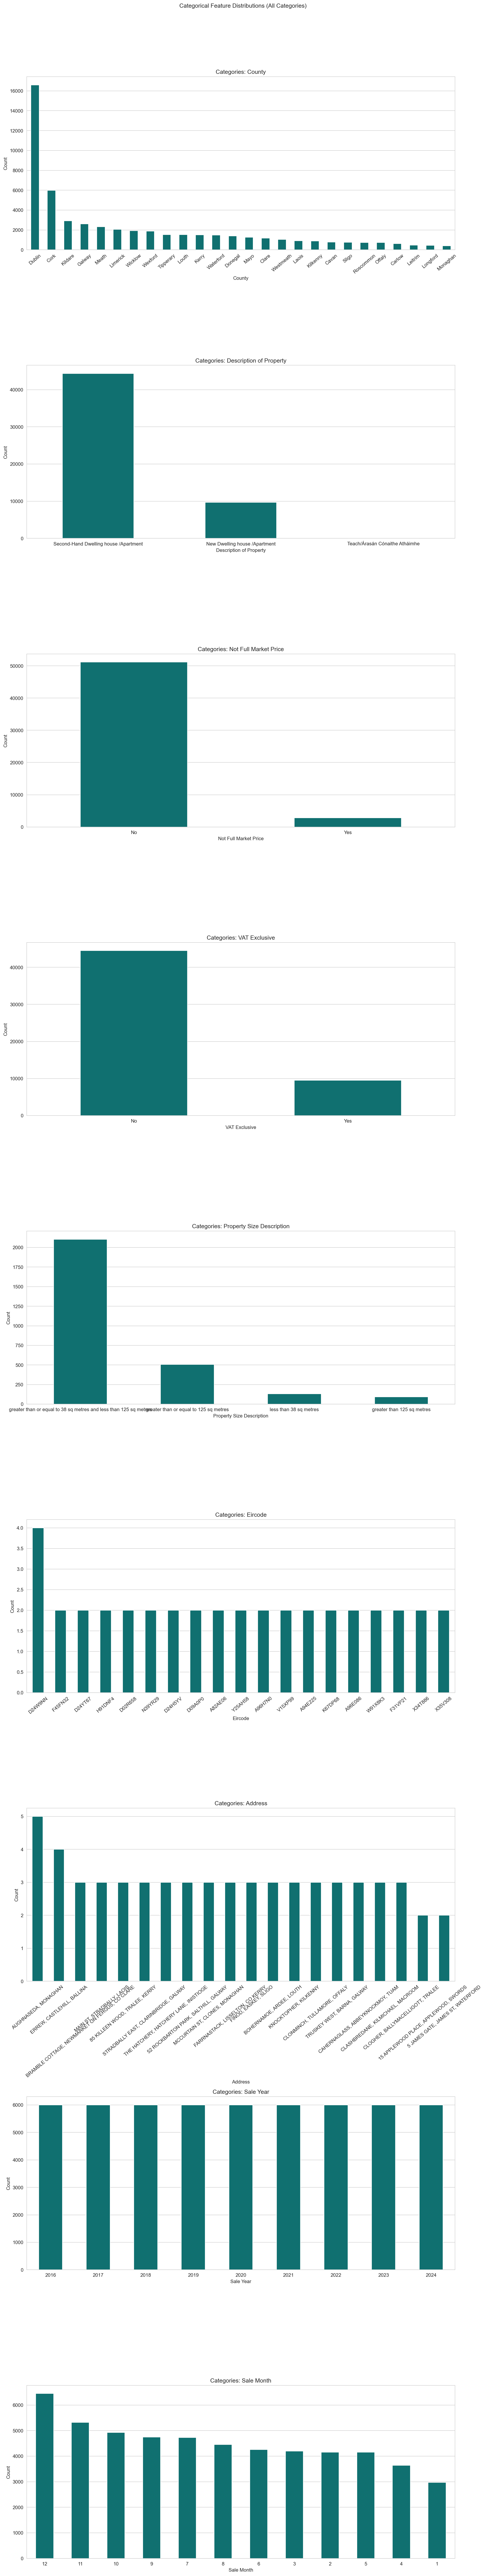

In [17]:
#  category bar plots for selected categorical columns (combined layout)
candidate_cats = [
    'County',
    'Description of Property',
    'Not Full Market Price',
    'VAT Exclusive',
    'Property Size Description',
    'Eircode',
    'Address',
    'Sale Year',
    'Sale Month'
]

plot_cols = [c for c in candidate_cats if c in df.columns]

ncols = 1
nrows = int(np.ceil(len(plot_cols) / ncols))

# Use DPI to control output resolution for report-quality figures
fig, axes = plt.subplots(
    nrows,
    ncols,
    figsize=(14, 8 * nrows),
    dpi=160
)
axes = np.array(axes).reshape(-1)

for i, c in enumerate(plot_cols):
    freq = df[c].value_counts(dropna=False)
    cardinality = len(freq)

    if cardinality > 50:
        freq = freq.head(20)

    sns.barplot(
        x=freq.index.astype(str),
        y=freq.values,
        color='teal',
        width=0.5,
        ax=axes[i]
    )

    axes[i].set_title(f'Categories: {c}')
    axes[i].set_xlabel(c)
    axes[i].set_ylabel('Count')

    if cardinality > 12:
        axes[i].tick_params(axis='x', rotation=40)
    else:
        axes[i].tick_params(axis='x', rotation=0)


# Remove empty subplot slots when number of features is odd
for j in range(len(plot_cols), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Categorical Feature Distributions (All Categories)', y=1.02)
plt.tight_layout()
plt.show()


## 10.5) VAT Exclusive=No vs Description of Property
检查 `VAT Exclusive = No` 记录对应的 `Description of Property` 分布，并验证是否主要为二手房。


Rows with VAT Exclusive = 'No': 44486


,Description of Property,count,pct_%
0,Second-Hand Dwelling house /Apartment,44332,99.65
1,New Dwelling house /Apartment,151,0.34
2,Teach/Árasán Cónaithe Atháimhe,3,0.01


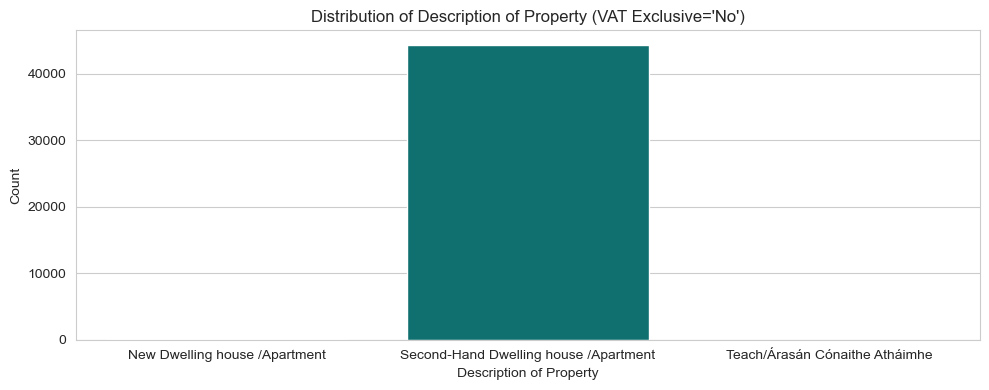

Rows not matching expected label 'Second-Hand Dwelling house /Apartment': 154


,VAT Exclusive,Description of Property
167,No,New Dwelling house /Apartment
316,No,New Dwelling house /Apartment
1182,No,New Dwelling house /Apartment
1615,No,New Dwelling house /Apartment
1716,No,New Dwelling house /Apartment
1862,No,New Dwelling house /Apartment
2047,No,New Dwelling house /Apartment
2305,No,New Dwelling house /Apartment
2502,No,New Dwelling house /Apartment
2739,No,New Dwelling house /Apartment


In [18]:
# Analyze Description of Property distribution when VAT Exclusive == 'No'
required_cols = ['VAT Exclusive', 'Description of Property']
if not set(required_cols).issubset(df.columns):
    print('Required columns not found:', required_cols)
else:
    vat_no_mask = df['VAT Exclusive'].astype(str).str.strip().eq('No')
    vat_no_df = df.loc[vat_no_mask, ['VAT Exclusive', 'Description of Property']].copy()

    total_vat_no = len(vat_no_df)
    print(f"Rows with VAT Exclusive = 'No': {total_vat_no}")

    desc_dist = (
        vat_no_df['Description of Property']
        .value_counts(dropna=False)
        .rename_axis('Description of Property')
        .reset_index(name='count')
    )
    desc_dist['pct_%'] = (desc_dist['count'] / total_vat_no * 100).round(2)
    display(desc_dist)

    plt.figure(figsize=(10, 4))
    sns.barplot(data=desc_dist, x='Description of Property', y='count', color='teal')
    plt.title("Distribution of Description of Property (VAT Exclusive='No')")
    plt.xlabel('Description of Property')
    plt.ylabel('Count')
    # plt.xticks(rotation=25, ha='right')
    plt.tight_layout()
    plt.show()

    expected_label = 'Second-Hand Dwelling house /Apartment'
    not_expected = vat_no_df[~vat_no_df['Description of Property'].astype(str).str.strip().eq(expected_label)]
    print(f"Rows not matching expected label '{expected_label}': {len(not_expected)}")
    if len(not_expected) > 0:
        display(not_expected.head(20))


## 10.6) Price Trend by Time 价格时间趋势

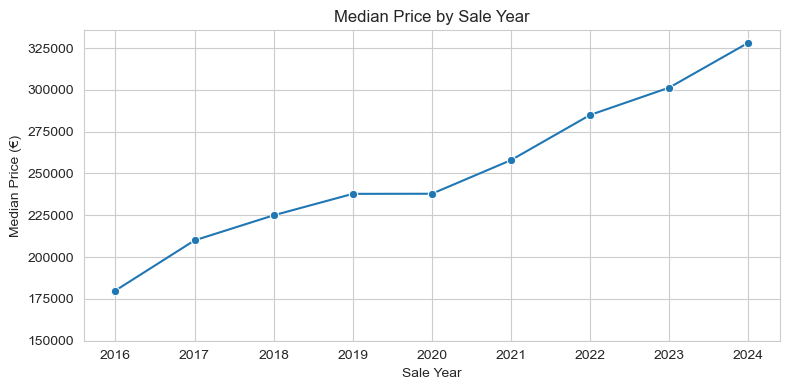

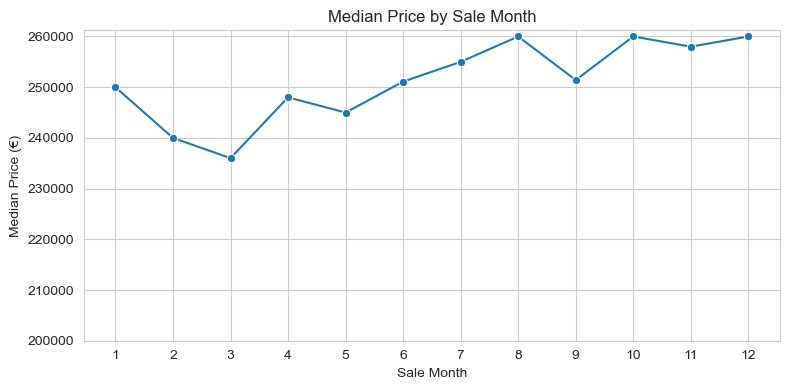

In [19]:
# Median price trend by Sale Year and Sale Month
if {'Price (€)', 'Sale Year'}.issubset(df.columns):
    yr = (
        df.dropna(subset=['Price (€)', 'Sale Year'])
          .groupby('Sale Year', observed=False)['Price (€)']
          .median() # 每月价格中位数
          .sort_index()
    )
    plt.figure(figsize=(8, 4))
    sns.lineplot(x=yr.index.astype(str), y=yr.values, marker='o')
    plt.title('Median Price by Sale Year')
    plt.xlabel('Sale Year')
    plt.ylabel('Median Price (€)')
    plt.tight_layout()
    plt.ylim(bottom=150000)
    plt.show()

if {'Price (€)', 'Sale Month'}.issubset(df.columns):
    mo = (
        df.dropna(subset=['Price (€)', 'Sale Month'])
          .groupby('Sale Month', observed=False)['Price (€)']
          .median()
          .sort_index()
    )
    plt.figure(figsize=(8, 4))
    sns.lineplot(x=mo.index.astype(str), y=mo.values, marker='o')
    plt.title('Median Price by Sale Month')
    plt.xlabel('Sale Month')
    plt.ylabel('Median Price (€)')
    plt.tight_layout()
    plt.ylim(bottom=200000)
    plt.show()


## 10.7) Price by County Boxplot 按地区价格箱线图

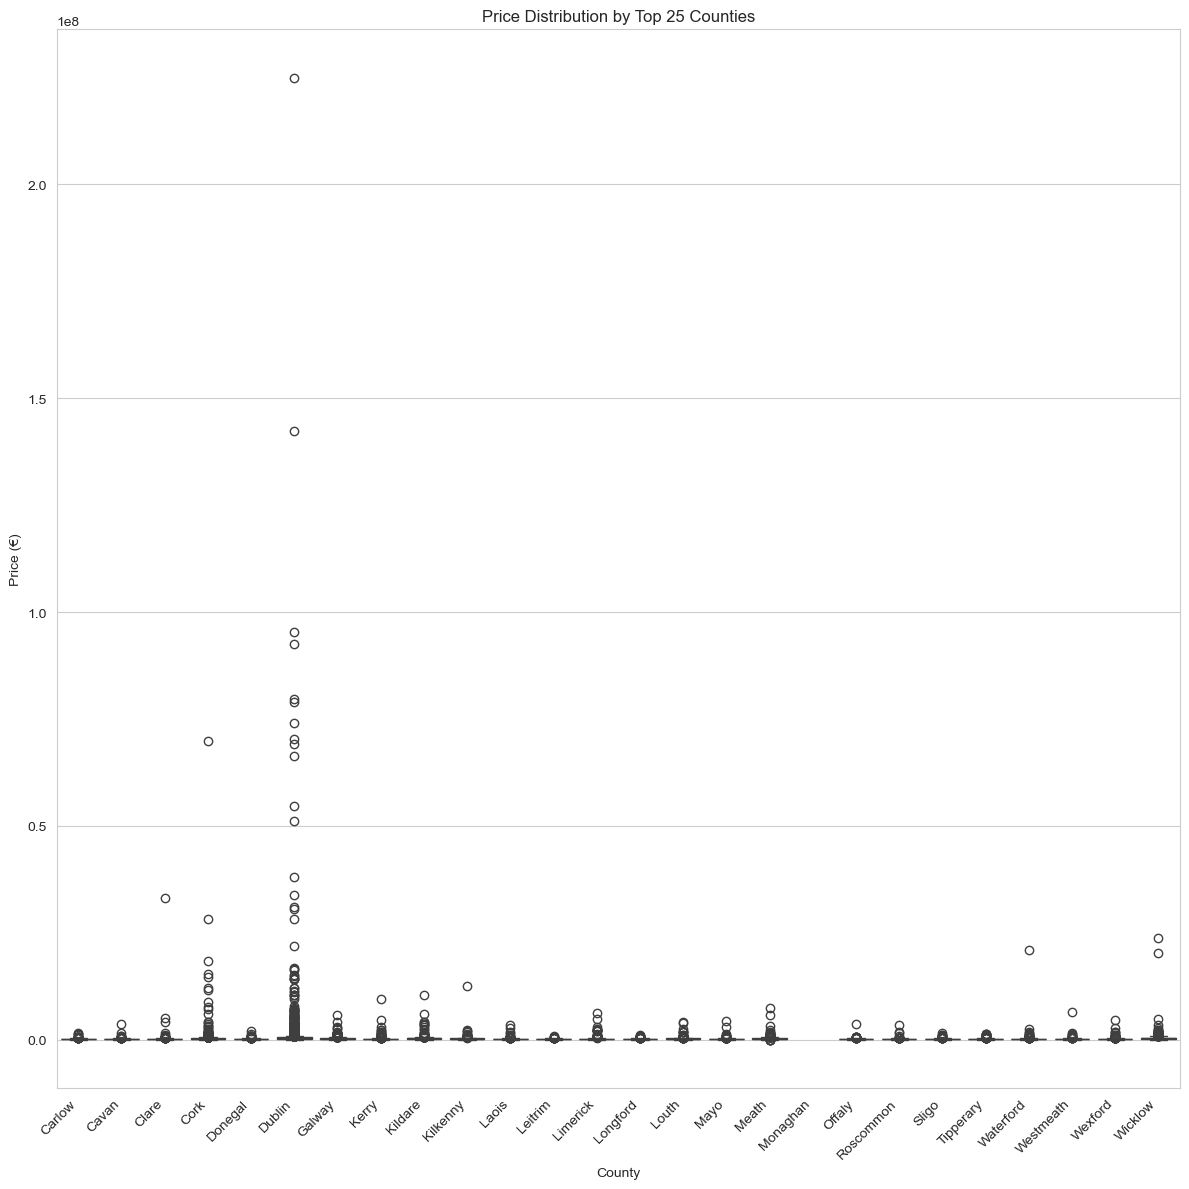

In [20]:

if {'Price (€)', 'County'}.issubset(df.columns):
    top_n = 25
    top_counties = df['County'].value_counts(dropna=True).head(top_n).index
    tmp = df[df['County'].isin(top_counties)].copy()

    plt.figure(figsize=(12, 12))
    sns.boxplot(data=tmp, x='County', y='Price (€)')
    plt.title(f'Price Distribution by Top {top_n} Counties')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


## 10.8) Comprehensive Summary and Export 综合汇总与导出

In [21]:
# Save DQR tables to CSV
numeric_out = 'PropertyPrice-DataQualityReport-NumericFeatures-Summary-Table.csv'
categorical_out = 'PropertyPrice-DataQualityReport-CategoricalFeatures-Summary-Table.csv'

if 'numeric_dqr' in globals() and not numeric_dqr.empty:
    numeric_dqr.to_csv(numeric_out, index_label='Feature')
    print(f"Saved: {numeric_out}")
else:
    print('Numeric DQR table is empty, not saved.')

if 'categorical_dqr' in globals() and not categorical_dqr.empty:
    categorical_dqr.to_csv(categorical_out, index_label='Feature')
    print(f"Saved: {categorical_out}")
else:
    print('Categorical DQR table is empty, not saved.')


Saved: PropertyPrice-DataQualityReport-NumericFeatures-Summary-Table.csv
Saved: PropertyPrice-DataQualityReport-CategoricalFeatures-Summary-Table.csv


## 10.8.1) Row/Column Removal Decision Log (Template)
用于 DQR 中 `after row/column removal` 的证据留存。请手动补充 `Final Decision` 与 `Reason`。


In [29]:
import pandas as pd
from IPython.display import Markdown, display

plot_findings = [
    {
        'Plot Section': 'Missingness Visual',
        'Related Features': 'Eircode, Property Size description',
        'Finding 1': 'over 60% of Eircode values are missing, indicating it is not a reliable feature for analysis.',
        'Finding 2': 'over 80% of Property Size description values are missing, suggesting it is also not useful for analysis.',
        'Finding 3': 'no solid feature to present location-based insights and address has so many unique values that it is not suitable for analysis.',
        'Potential Action (for DQP)': 'Drop Eircode and Property Size description columns to improve data quality and reduce noise in analysis.'
    },
       {
        'Plot Section': 'Duplicate Missingness Visual',
        'Related Features': 'all features',
        'Finding 1': 'there are 9 rows which are duplicated.',
        'Potential Action (for DQP)': 'Drop duplicated rows'
    },
    {
        'Plot Section': 'Categorical Feature Distributions',
        'Related Features': 'County, Property Type',
        'Finding 1': 'County has 26 unique values, with Dublin and Cork being the most common.',
        'Finding 2': 'Description of Property has 3 unique values, with the majority is "Second-House".',
        'Finding 3': 'Not Full Market Price has 2 unique values, with the majority being "N".',
        'Finding 4': 'VAT Exclusive has 2 unique values, with the majority being "N". with feature "Second-House"',
        'Finding 5': 'VAT Exclusive has 2 unique values, with the majority being "N".',
        'Finding 6': 'Eircode has 50000+ unique values, making it unsuitable for analysis.',
        'Finding 7': 'Property Size description has 50000+ unique values, making it unsuitable for analysis.',
        'Finding 8': 'Address has 50000+ unique values, making it unsuitable for analysis.',
        'Finding 9': 'Sale year has 12 unique values, with very average distribution across years.',
        'Finding 10': 'Sale month has 12 unique values, which cardinality from 12 to 1 decreased by degrees .',
        'Potential Action (for DQP)': '1-keep all features except Eircode and Property Size description for analysis, as they provide useful categorical information while maintaining manageable cardinality.2-Engineer ericode into zone number and address (Non-overlapping parts with Ericode) into zone number before dropping them.'
    },
    {
        'Plot Section': 'Price Distribution (Raw/Log/Boxplot)',
        'Related Features': 'Price (€)',
        'Finding 1': 'Price is right-skewed, with most values concentrated in a narrow range.',
        'Finding 2': 'There are several outliers in the price data.',
        'Potential Action (for DQP)': 'Clamp the price to 5% and 95% percentiles to remove extreme outliers.'
    },
    {
        'Plot Section': 'Price Trend by Time',
        'Related Features': 'Sale Year, Sale Month, Price (€)',
        'Finding 1': 'Medium price feature match year keep going up from 2016 to 2022 due to the current inflation, with a slight dip in 2020 likely due to the COVID-19 pandemic.',
        'Finding 2': 'Medium price feature match month shows a seasonal pattern but flatter compared with year parttern, it increase from March to Dec, and drop  in the winter months (December-February).',
        'Potential Action (for DQP)': 'Just Engineer Date of Sale (dd/mm/yyyy)\tinto Sale Year and Sale Month, and keep them for analysis to capture temporal trends in property prices.'
    },
    {
        'Plot Section': 'Price by County Boxplot',
        'Related Features': 'County, Price (€)',
        'Finding 1': 'Price distribution varies significantly across counties, with Dublin and Cork showing higher median prices compared to other counties.',
        'Finding 2': 'In addition to Dublin, Cork/Wicklow also has higher-priced transactions, but the overall density is still concentrated in the lower price range.',
        'Potential Action (for DQP)': 'keep'
    }
]

def esc(x: str) -> str:
    return str(x).replace("|", "\\|").replace("\n", " ")

lines = []
lines.append("| Plot Section | Related Features | Findings | Potential Action (for DQP) |")
lines.append("|---|---|---|---|")

for p in plot_findings:
    finding_keys = sorted([k for k in p if k.startswith("Finding ")], key=lambda k: int(k.split()[1]))
    findings_text = "<br>".join([f"{k}: {esc(p[k])}" for k in finding_keys])
    lines.append(
        f"| {esc(p.get('Plot Section',''))} | {esc(p.get('Related Features',''))} | {findings_text} | {esc(p.get('Potential Action (for DQP)',''))} |"
    )

md_table = "\n".join(lines)
display(Markdown(md_table))
pd.DataFrame(plot_findings).to_csv("plot_findings.csv", index=False)



| Plot Section | Related Features | Findings | Potential Action (for DQP) |
|---|---|---|---|
| Missingness Visual | Eircode, Property Size description | Finding 1: over 60% of Eircode values are missing, indicating it is not a reliable feature for analysis.<br>Finding 2: over 80% of Property Size description values are missing, suggesting it is also not useful for analysis.<br>Finding 3: no solid feature to present location-based insights and address has so many unique values that it is not suitable for analysis. | Drop Eircode and Property Size description columns to improve data quality and reduce noise in analysis. |
| Duplicate Missingness Visual | all features | Finding 1: there are 9 rows which are duplicated. | Drop duplicated rows |
| Categorical Feature Distributions | County, Property Type | Finding 1: County has 26 unique values, with Dublin and Cork being the most common.<br>Finding 2: Description of Property has 3 unique values, with the majority is "Second-House".<br>Finding 3: Not Full Market Price has 2 unique values, with the majority being "N".<br>Finding 4: VAT Exclusive has 2 unique values, with the majority being "N". with feature "Second-House"<br>Finding 5: VAT Exclusive has 2 unique values, with the majority being "N".<br>Finding 6: Eircode has 50000+ unique values, making it unsuitable for analysis.<br>Finding 7: Property Size description has 50000+ unique values, making it unsuitable for analysis.<br>Finding 8: Address has 50000+ unique values, making it unsuitable for analysis.<br>Finding 9: Sale year has 12 unique values, with very average distribution across years.<br>Finding 10: Sale month has 12 unique values, which cardinality from 12 to 1 decreased by degrees . | 1-keep all features except Eircode and Property Size description for analysis, as they provide useful categorical information while maintaining manageable cardinality.2-Engineer ericode into zone number and address (Non-overlapping parts with Ericode) into zone number before dropping them. |
| Price Distribution (Raw/Log/Boxplot) | Price (€) | Finding 1: Price is right-skewed, with most values concentrated in a narrow range.<br>Finding 2: There are several outliers in the price data. | Clamp the price to 5% and 95% percentiles to remove extreme outliers. |
| Price Trend by Time | Sale Year, Sale Month, Price (€) | Finding 1: Medium price feature match year keep going up from 2016 to 2022 due to the current inflation, with a slight dip in 2020 likely due to the COVID-19 pandemic.<br>Finding 2: Medium price feature match month shows a seasonal pattern but flatter compared with year parttern, it increase from March to Dec, and drop  in the winter months (December-February). | Just Engineer Date of Sale (dd/mm/yyyy)	into Sale Year and Sale Month, and keep them for analysis to capture temporal trends in property prices. |
| Price by County Boxplot | County, Price (€) | Finding 1: Price distribution varies significantly across counties, with Dublin and Cork showing higher median prices compared to other counties.<br>Finding 2: In addition to Dublin, Cork/Wicklow also has higher-priced transactions, but the overall density is still concentrated in the lower price range. | keep |

## 10.9) Data Quality Plan 数据质量处理计划
按 Lab3 模板给出每个特征的问题与策略，后续可人工细化。

### 10.9.1) DQP To-Do List (Manual)
- [ ] VAT rule for new house: only when `Description of Property == 'New Dwelling house /Apartment'` and `VAT Exclusive = Yes`, adjust price by adding VAT (`Price_with_VAT = Price * 1.135`).
- [ ] Confirm whether model target should use VAT-adjusted price or keep original reported price (document rationale).
- [ ] Log affected record count and keep both columns (`Price (€)` and `Price_Adjusted_VAT`) for auditability.


In [ ]:
# Build a draft Data Quality Plan
feature_types = df.dtypes.astype(str)
missing_pct_map = (df.isna().mean() * 100)

rows = []
for col_name in df.columns:
    ftype = feature_types[col_name]
    miss = float(missing_pct_map[col_name])

    issues = []
    actions = []

    if miss > 30:
        issues.append(f'High missing values ({miss:.1f}%)')
        actions.append('Assess business relevance; drop feature if non-critical, otherwise apply engineer')
    elif miss > 0:
        issues.append(f'Missing values ({miss:.1f}%)')
        actions.append('keep feature just in case further analysis may reveal its value')

    if col_name == 'Price (€)':
        issues.append('Potential skewness and high-end outliers')
        actions.append('Use log1p(Price) for modeling; apply percentile capping only when justified')

    if col_name == 'VAT Exclusive':
        issues.append("Only for Description of Property == 'New Dwelling house /Apartment', VAT Exclusive=Yes implies +13.5% VAT adjustment")
        actions.append("For New Dwelling house /Apartment with VAT Exclusive=Yes, create VAT-adjusted feature: Price * 1.135")

    if col_name in ['Eircode', 'Address']:
        issues.append('High-cardinality text/location feature')
        actions.append('Extract compact zone number, then drop raw high-cardinality field')

    if not issues:
        issues = ['No major issue detected']
        actions = ['Retain feature as derived from Date of Sale']

    rows.append({
        'Feature': col_name,
        'Feature Type': ftype,
        'Data Quality Issue': '\n'.join(issues),
        'Handling Strategy': '\n'.join(actions)

    })

quality_plan_df = pd.DataFrame(rows)
display(quality_plan_df.style.set_properties(**{"white-space": "pre-wrap"}))
plan_out = 'PropertyPrice-DataQualityPlan-Draft.csv'
quality_plan_df.to_csv(plan_out, index=False)
print(f"Saved: {plan_out}")


,Feature,Feature Type,Data Quality Issue,Handling Strategy
0,Date of Sale (dd/mm/yyyy),datetime64[us],No major issue detected,Retain feature without transformation
1,Address,str,High-cardinality text/location feature,"Extract compact location signal (e.g., zone), then drop raw high-cardinality field"
2,County,category,No major issue detected,Retain feature without transformation
3,Eircode,str,High missing values (68.7%) High-cardinality text/location feature,"Assess business relevance; drop feature if non-critical, otherwise apply rule-based imputation Extract compact location signal (e.g., zone), then drop raw high-cardinality field"
4,Price (€),float64,Potential skewness and high-end outliers,Use log1p(Price) for modeling; apply percentile capping only when justified
5,Not Full Market Price,category,No major issue detected,Retain feature without transformation
6,VAT Exclusive,category,"Only for Description of Property == 'New Dwelling house /Apartment', VAT Exclusive=Yes implies +13.5% VAT adjustment","For New Dwelling house /Apartment with VAT Exclusive=Yes, create VAT-adjusted feature: Price * 1.135"
7,Description of Property,category,No major issue detected,Retain feature without transformation
8,Property Size Description,category,High missing values (94.7%),"Assess business relevance; drop feature if non-critical, otherwise apply rule-based imputation"
9,Sale Year,category,No major issue detected,Retain feature without transformation


Saved: PropertyPrice-DataQualityPlan-Draft.csv
